# Quantum Dot Tuner

Procedure is as follows,

1. Define your station set-up using QCoDeS
2. Build your device and connect your gates to the station
3. Feed your device to the tuner and begin characterization!

### Import Modules

In [1]:
from qd_device_tuner.chip import *
from qd_device_tuner.tuners.single_charge_transistor import *

import qcodes as qc

### Connect to Station

In [2]:
csg_station = qc.Station(config_file="station_config.yaml")
csg_station.load_instrument('sim900')
csg_station.load_instrument('agilent')

sim900 = csg_station.sim900
agilent = csg_station.agilent

Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.76s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.05s


### Build Chip

In [3]:
# Constructs an SET following this kind of geometry
#     [     L      ]
# [S] [LB] <QD> [RB] [D]
#          [P]

# Define ohmics / gates and connect them to their respective voltage channels
S = Source(
    name="source", 
    source=sim900.volt_1, 
    scale=1.0e-2, # Voltage divider
    step=0.01, 
    bounds=0.05)
D = Drain(name="drain", 
          source=agilent.volt, 
          scale=1.0e-9, # Pre-amp sensitivity
          offset=0.0, # Pre-amp offset
          bounds=1.0)

LB = Barrier(name="leftbarrier", source=sim900.volt_2, step = 0.01, bounds=(0.2, 1))
P = Plunger(name="plunger", source=sim900.volt_3, step = 0.2, bounds=(-0.1, 1.5))
RB = Barrier(name="rightbarrier", source=sim900.volt_4,step = 0.01, bounds=(0.2, 1.2))

L = Top(name="top", source=sim900.volt_5,  step = 0.01,bounds=(0, 2))

# Build device(s)
SET = Device(
    name="D45",
    charge_carrier="e",
    operation_mode="acc",
    minimum_current_threshold=0.05e-9,
    maximum_current_threshold=1.5e-9
)
SET.add_source(S)
SET.add_drain(D)
SET.add_barrier(LB)
SET.add_plunger(P)
SET.add_barrier(RB)
SET.add_top(L)

# Build Chip
chip = Chip(
    name="N44"
)

chip.add_device(SET)

### Create Data Acquisition object

In [4]:
acq = Acquisition(csg_station)
acq.create_database(database_name=chip.name, save_dir=".")
acq.create_experiment(experiment_name="characterization", sample_name=SET.name)

### Give Device / Acquisition to 'Tuner'

In [5]:
tuner = SingleChargeTransistorTuner(
    device=chip.D45, 
    acquisition=acq,
    save_dir=Path(".")
)

In [6]:
tuner.ground_device()

In [7]:
tuner.apply_bias(0.01)

Starting experimental run with id: 136. Using 'qcodes.dataset.dond'


  0%|          | 0/21 [00:00<?, ?it/s]

Did not cross minimum threshold of 5e-11 A


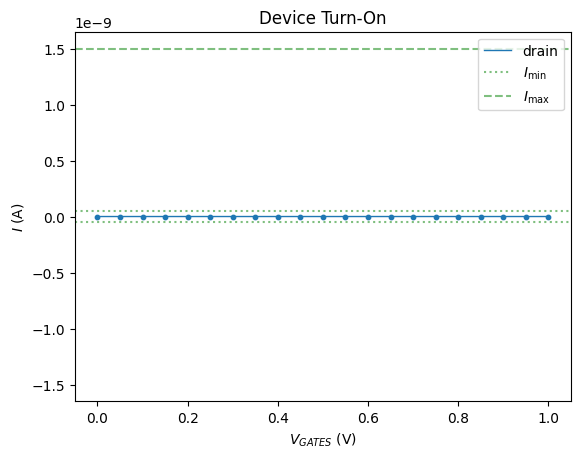

In [8]:
turn_on_data = tuner.turn_on()

In [9]:
tuner.device.turns_on
tuner.device.turn_on_voltage = 0.5
tuner.device.saturation_voltage = 1

Starting experimental run with id: 137. Using 'qcodes.dataset.dond'


  0%|          | 0/81 [00:00<?, ?it/s]

Unable to pinch off below 5e-11 A
Starting experimental run with id: 138. Using 'qcodes.dataset.dond'


  0%|          | 0/81 [00:00<?, ?it/s]

Unable to pinch off below 5e-11 A


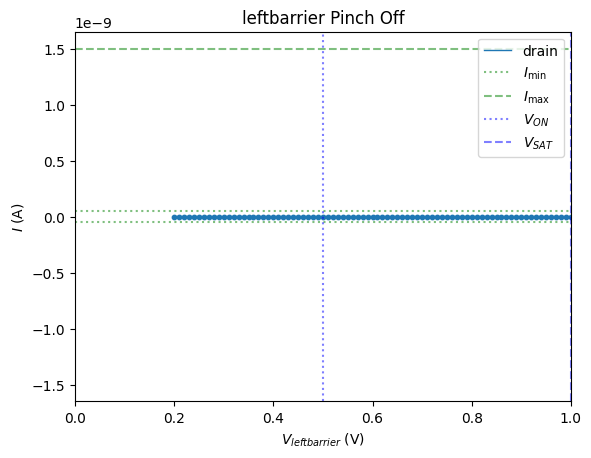

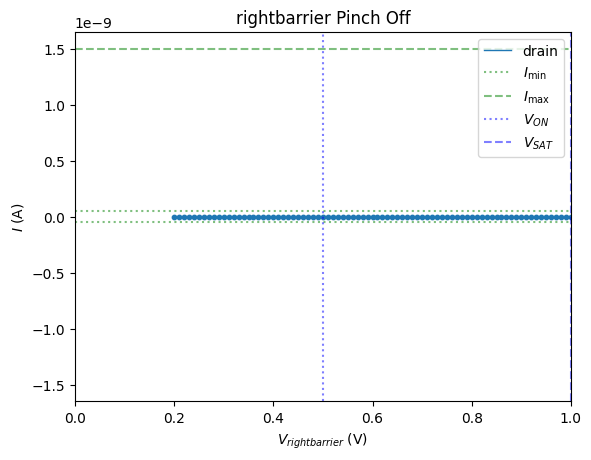

In [10]:
pinch_off_data = tuner.pinch_off()

In [11]:
tuner.device.leftbarrier.pinch_off_voltage = 0.45
tuner.device.leftbarrier.pinch_off_width = 0.05

tuner.device.rightbarrier.pinch_off_voltage = 0.4
tuner.device.rightbarrier.pinch_off_width = 0.1

Starting experimental run with id: 139. Using 'qcodes.dataset.do2d'


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

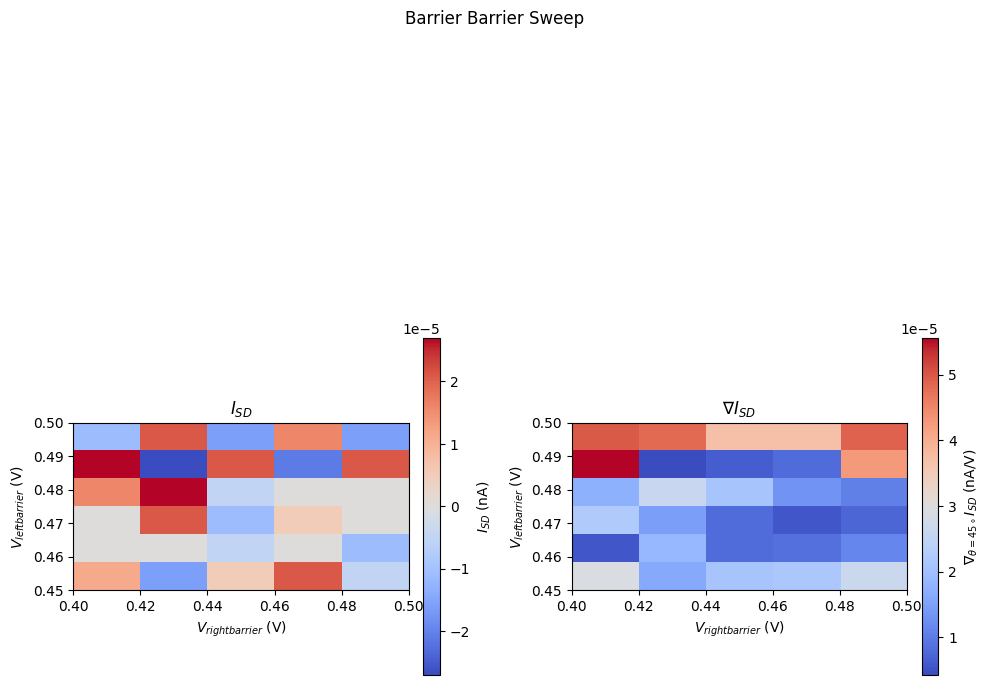

In [12]:
bb_sweep_data = tuner.sweep_barriers()

In [13]:
# tuner.coulomb_blockade()

Starting experimental run with id: 140. Using 'qcodes.dataset.do2d'


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,plunger,source,drain
0,-0.1,-0.05,-2.100000e-14
1,-0.1,-0.04,-1.100000e-14
2,-0.1,-0.03,2.700000e-14
3,-0.1,-0.02,-5.000000e-15
4,-0.1,-0.01,-2.700000e-14
...,...,...,...
94,1.5,0.01,5.000000e-15
95,1.5,0.02,0.000000e+00
96,1.5,0.03,-1.600000e-14
97,1.5,0.04,-1.600000e-14


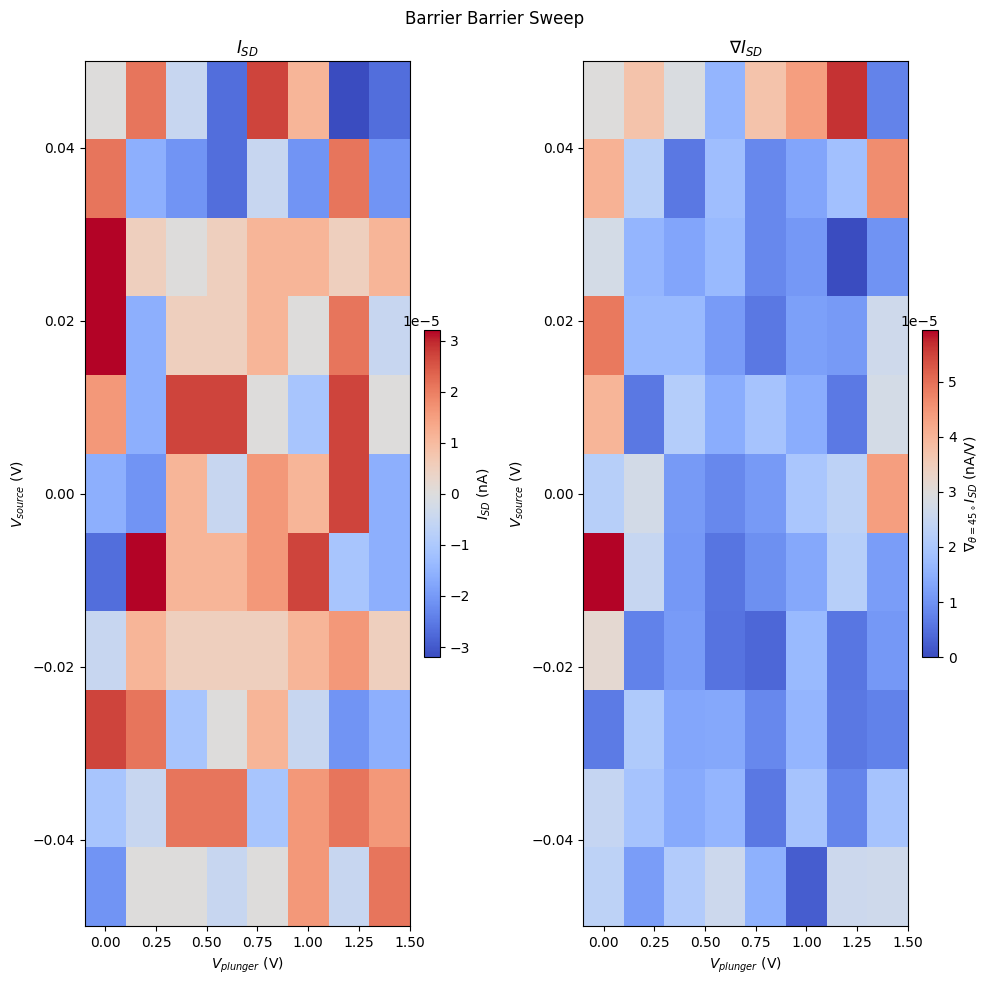

In [14]:
tuner.coulomb_diamonds()

In [15]:
# agilent.NPLC(0.02) # Integration time of 0.02/60 seconds ~ 0.33 milliseconds
# fs = 1
# tuner.current_trace(
#     f_sampling=fs,
#     t_capture=10,
#     plot_psd=False
# )